<a href="https://colab.research.google.com/github/SirwaniViren/MSc-Gousto-Project/blob/main/initial_framework_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import math
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from random import randrange
import matplotlib.pyplot as plt
import os

In [17]:
random.seed(42)

# Creating Synthetic Data
Here we have a few functions which are used to create synthetic data that we can later work with to allocate the orders to their respecitve factories.

In [18]:
def create_eligibility_dict(num_factories, num_items):
    items = list(range(100, 100 + num_items * 10, 10))
    eligibility_dict = {}

    # Start with a base number of items for the first factory
    num_eligible_items = random.randint(5, 15)

    for i in range(1, num_factories + 1):
        if i == num_factories:
            # Last factory gets all items
            eligibility_dict[f"F{i}"] = items
        else:
            eligibility_dict[f"F{i}"] = items[:num_eligible_items]
            # Randomly determine the number of additional items for the next factory
            num_eligible_items += random.randint(1, 10)
            # Ensure num_eligible_items does not exceed the total number of items
            num_eligible_items = min(num_eligible_items, num_items)

    return eligibility_dict

In [19]:
def create_factory_caps(num_factory, max_boxes):
    factory_caps = {}
    # Start with an initial capacity for the first factory
    cap = random.randint(1, max_boxes // 10)  # Starting with a base capacity

    for i in range(1, num_factory + 1):
        if i == num_factory:
            # Last factory gets infinite capacity
            factory_caps[f"F{i}"] = float('inf')
        else:
            factory_caps[f"F{i}"] = cap
            # Randomly increase the capacity for the next factory
            cap += random.randint(1, max_boxes // 10)
            # Ensure the capacity does not exceed max_boxes
            cap = min(cap, max_boxes)

    return factory_caps


def generate_total_boxes(factory_caps, min_extra_boxes, max_extra_boxes, lead_day):
    # Calculate total capacity excluding the infinite capacity
    finite_capacity = sum(cap for cap in factory_caps.values() if cap != float('inf'))

    # Add a random number of extra boxes to exceed the total capacity
    extra_boxes = random.randint(min_extra_boxes, max_extra_boxes)
    total_boxes = finite_capacity + extra_boxes

    # Determine the proportion of simulated orders based on the lead day
    if lead_day == 0:
        simulated_order_percentage = 0
    else:
        # Simulate orders percentage decreases linearly with lead day
        simulated_order_percentage = max(0, min(100, (lead_day / 18) * 100))

    # Calculate number of real and simulated orders
    num_simulated_orders = int(total_boxes * simulated_order_percentage / 100)
    num_real_orders = total_boxes - num_simulated_orders

    return num_real_orders, num_simulated_orders

In [20]:
def generate_order_list(start_order_id, order_count, order_type, items, max_items_per_order=5):
    orders = []
    order_id = start_order_id

    while order_count > 0:
        num_items_in_order = min(random.randint(1, max_items_per_order), len(items))
        order_items = random.sample(items, num_items_in_order)
        for item in order_items:
            orders.append({'order_id': order_id, 'item_id': item, 'order_type': order_type})
        order_count -= 1
        order_id += 1

    return orders, order_id

def generate_orders(total_real_orders, total_simulated_orders, num_items, max_items_per_order=5):
    items = list(range(100, 100 + num_items * 10, 10))
    current_order_id = 1

    # Generate real orders
    real_orders, current_order_id = generate_order_list(current_order_id, total_real_orders, 'real', items, max_items_per_order)

    # Generate simulated orders
    simulated_orders, _ = generate_order_list(current_order_id, total_simulated_orders, 'simulated', items, max_items_per_order)

    # Combine real and simulated orders
    all_orders = real_orders + simulated_orders

    # Convert to DataFrame
    orders_df = pd.DataFrame(all_orders)
    return orders_df

In [21]:
def compute_orders_eligibility(orders_df, eligibility_dict):
    orders_eligibility = []

    for order_id in orders_df['order_id'].unique():
        order_items = orders_df[orders_df['order_id'] == order_id]['item_id'].tolist()
        order_type = orders_df[orders_df['order_id'] == order_id]['order_type'].iloc[0]
        eligible_factories = []
        for factory, items in eligibility_dict.items():
            if all(item in items for item in order_items):
                eligible_factories.append(factory)
        orders_eligibility.append({'order_id': order_id, 'eligibility': eligible_factories, 'order_type': order_type})

    orders_eligibility_df = pd.DataFrame(orders_eligibility)
    return orders_eligibility_df

# Implement Functions to produce synthetic data

In [22]:
# Define directories
order_dir = 'order_dataframes'
eligibility_dir = 'order_eligibility_dataframes'

# Create directories if they don't exist
os.makedirs(order_dir, exist_ok=True)
os.makedirs(eligibility_dir, exist_ok=True)

# Define factory caps and eligibility dictionary
num_factories = 20
num_items = 100
factory_caps = create_factory_caps(num_factories, 100)
eligibility_dict = create_eligibility_dict(num_factories, num_items)

# Loop through lead days from 18 to 0
for lead_day in range(18, -1, -1):
    num_real_orders, num_simulated_orders = generate_total_boxes(factory_caps, 1000, 2000, lead_day)
    orders_df = generate_orders(num_real_orders, num_simulated_orders, num_items)
    orders_eligibility_df = compute_orders_eligibility(orders_df, eligibility_dict)

    # Save DataFrames to files
    orders_df.to_csv(f'{order_dir}/orders_lead_day_{lead_day}.csv', index=False)
    orders_eligibility_df.to_csv(f'{eligibility_dir}/orders_eligibility_lead_day_{lead_day}.csv', index=False)

print("Order DataFrames and Order Eligibility DataFrames have been saved.")

Order DataFrames and Order Eligibility DataFrames have been saved.


In [23]:
def allocate_orders(allocated_orders, allocated_order_eligibility, allocated_factory_caps):
    # Initialize columns
    allocated_orders['site'] = 'not_routed'
    allocated_order_eligibility['allocated'] = False

    # Iterate through each factory except the catch-all
    for factory in list(allocated_factory_caps.keys())[:-1]:
        cap = allocated_factory_caps[factory]

        # Get set S of unrouted orders eligible to the current factory
        eligible_orders = allocated_order_eligibility[(allocated_order_eligibility['allocated'] == False) &
                                                      (allocated_order_eligibility['eligibility'].apply(lambda i: factory in i))]

        if len(eligible_orders) < cap:
            raise ValueError(f'Not enough eligible orders for {factory}')
        else:
            for _ in range(cap):
                if len(eligible_orders) == 0:
                    break
                # Pick a random order from the eligible list
                selected_order = eligible_orders.sample(1).iloc[0]
                order_id = selected_order['order_id']

                # Allocate items in allocated_orders
                allocated_orders.loc[allocated_orders['order_id'] == order_id, 'site'] = factory

                # Mark the order as allocated in allocated_order_eligibility
                allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

                # Update the eligible_orders to exclude the allocated order
                eligible_orders = eligible_orders[eligible_orders['order_id'] != order_id]

    # Allocate remaining orders to catch-all
    catch_all_factory = list(allocated_factory_caps.keys())[-1]
    remaining_orders = allocated_order_eligibility[allocated_order_eligibility['allocated'] == False]
    for order_id in remaining_orders['order_id']:
        allocated_orders.loc[allocated_orders['order_id'] == order_id, 'site'] = catch_all_factory
        allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

    return allocated_orders

# Allocate orders to factories
We have a function which greedily allocates the orders to factories. By greedy we mean allocate orders to factory 1 until we have reached its capacity, then move on to factory 2, etc ...

In [25]:
order_dir = 'order_dataframes'
eligibility_dir = 'order_eligibility_dataframes'
allocation_dir = 'allocations'

# Create the allocations directory if it doesn't exist
os.makedirs(allocation_dir, exist_ok=True)

for lead_day in range(18, -1, -1):
    # Load the DataFrames
    orders_df = pd.read_csv(f'{order_dir}/orders_lead_day_{lead_day}.csv')
    orders_eligibility_df = pd.read_csv(f'{eligibility_dir}/orders_eligibility_lead_day_{lead_day}.csv')

    # Allocate orders
    allocated_orders_df = allocate_orders(orders_df.copy(), orders_eligibility_df.copy(), factory_caps.copy())

    # Save the allocation DataFrame
    allocated_orders_df.to_csv(f'{allocation_dir}/allocation_lead_day_{lead_day}.csv', index=False)

print("Order allocations have been saved.")

Order allocations have been saved.


# Plot factory Capacities for each lead day

In [27]:
def plot_factory_capacities(allocated_orders_df, factory_caps, lead_day):
    # Aggregate the orders by site and type
    real_orders_agg = allocated_orders_df[allocated_orders_df['order_type'] == 'real'].groupby('site')['order_id'].nunique()
    simulated_orders_agg = allocated_orders_df[allocated_orders_df['order_type'] == 'simulated'].groupby('site')['order_id'].nunique()

    # Ensure all sites are included in the aggregation and in the correct order
    all_sites = list(factory_caps.keys())
    real_orders_agg = real_orders_agg.reindex(all_sites, fill_value=0)
    simulated_orders_agg = simulated_orders_agg.reindex(all_sites, fill_value=0)

    # Prepare data for plotting
    sites = all_sites
    real_volumes = real_orders_agg[sites].values
    simulated_volumes = simulated_orders_agg[sites].values
    capacities = [factory_caps[site] if site in factory_caps else 0 for site in sites]

    # Plot the data
    fig, ax = plt.subplots(figsize=(15, 9))
    bar_width = 0.6

    bars_real = ax.bar(sites, real_volumes, bar_width, color='blue', label='Real Orders')
    bars_simulated = ax.bar(sites, simulated_volumes, bar_width, bottom=real_volumes, color='orange', label='Simulated Orders')

    # Add capacity lines and labels
    for site, cap in zip(sites, capacities):
        if cap == float('inf'):
            cap_label = 'inf'
        else:
            cap_label = str(cap)
            ax.plot([site, site], [0, cap], color='red', linestyle='--')
            ax.text(site, cap, cap_label, ha='center', va='bottom', color='red')

    ax.set_xlabel('Factories')
    ax.set_ylabel('Number of Orders')
    ax.set_title(f'Factory Capacities - Lead Day {lead_day}')
    ax.legend()

    plt.show()

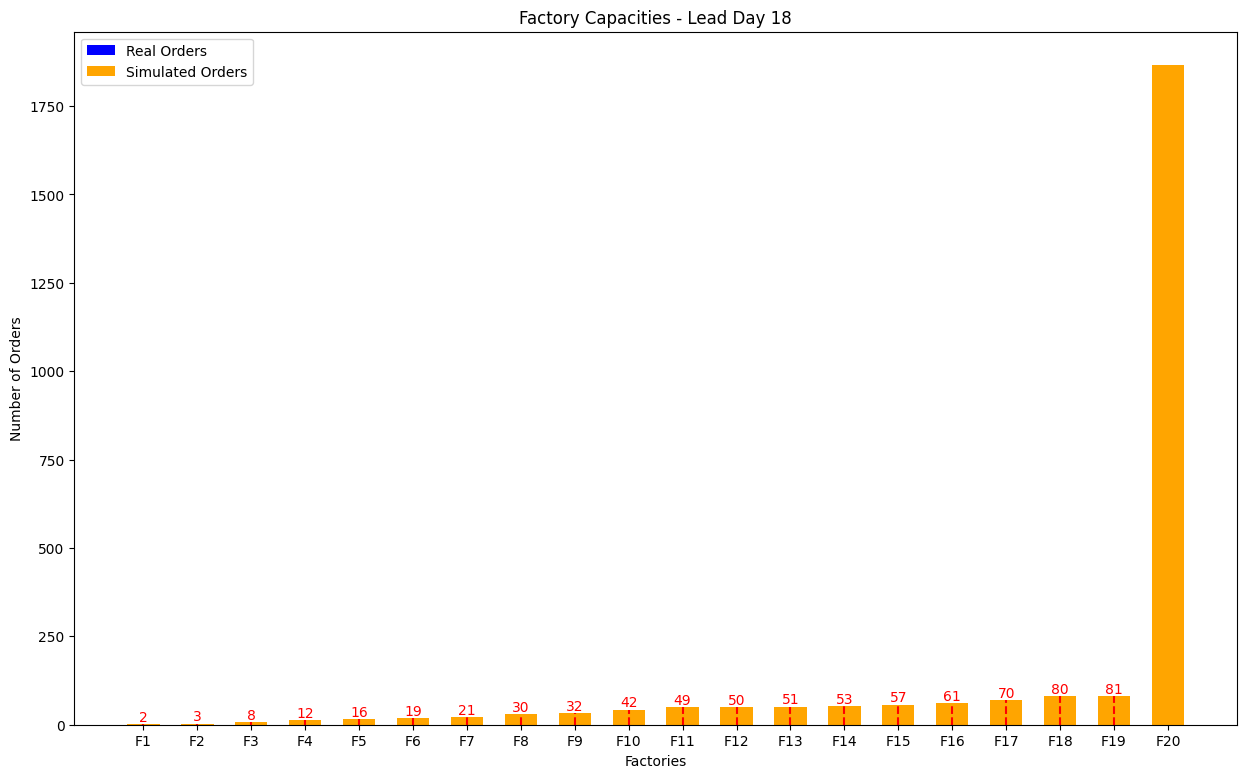

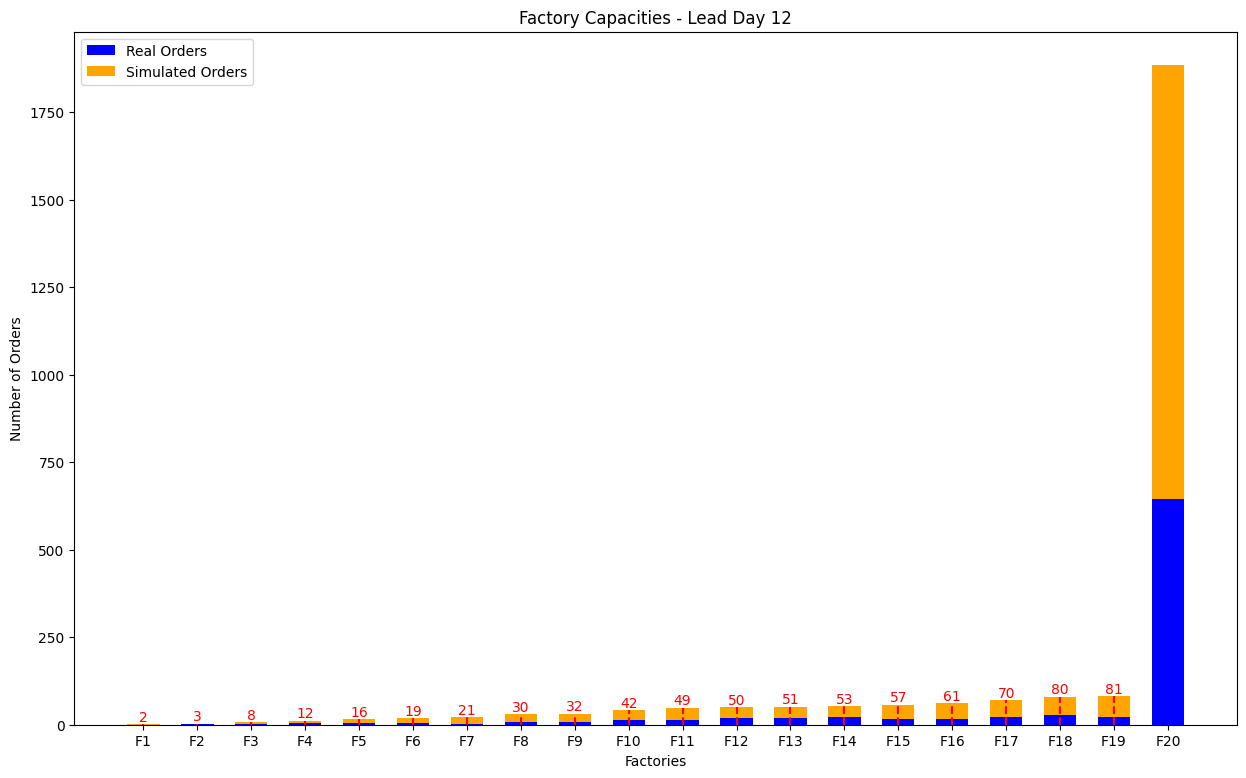

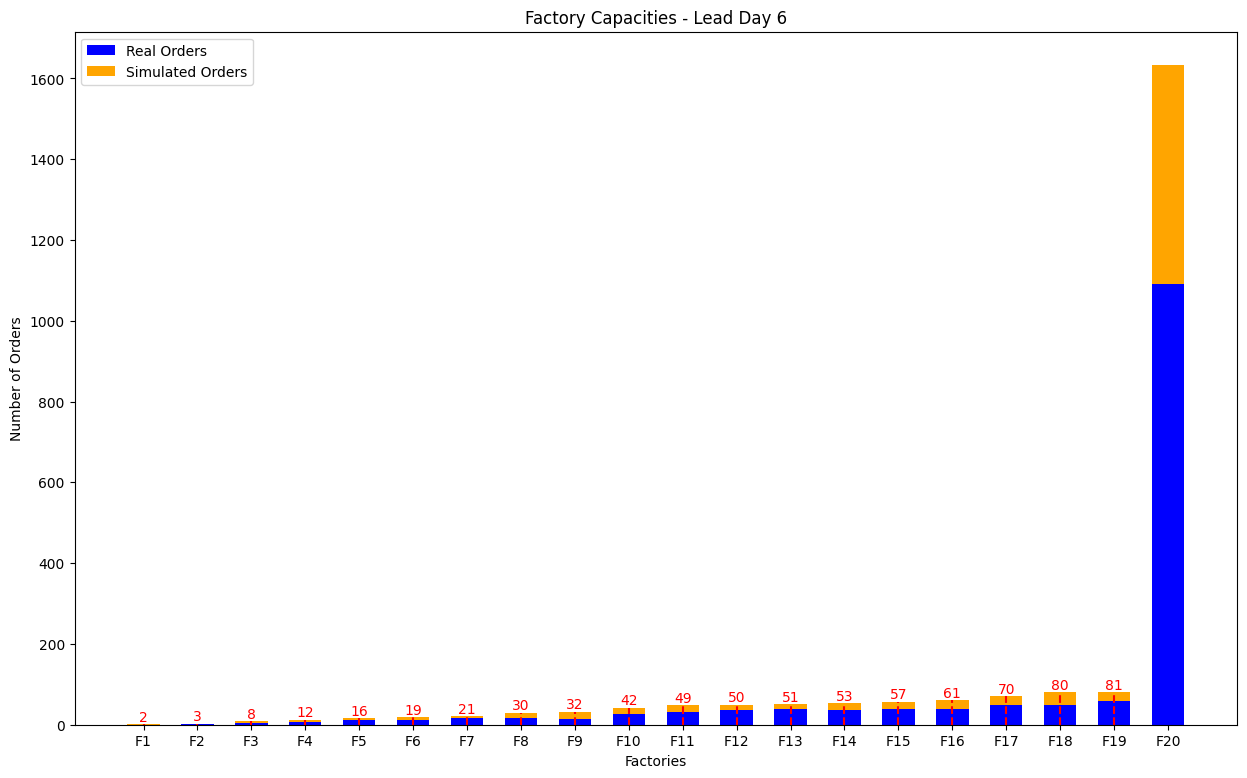

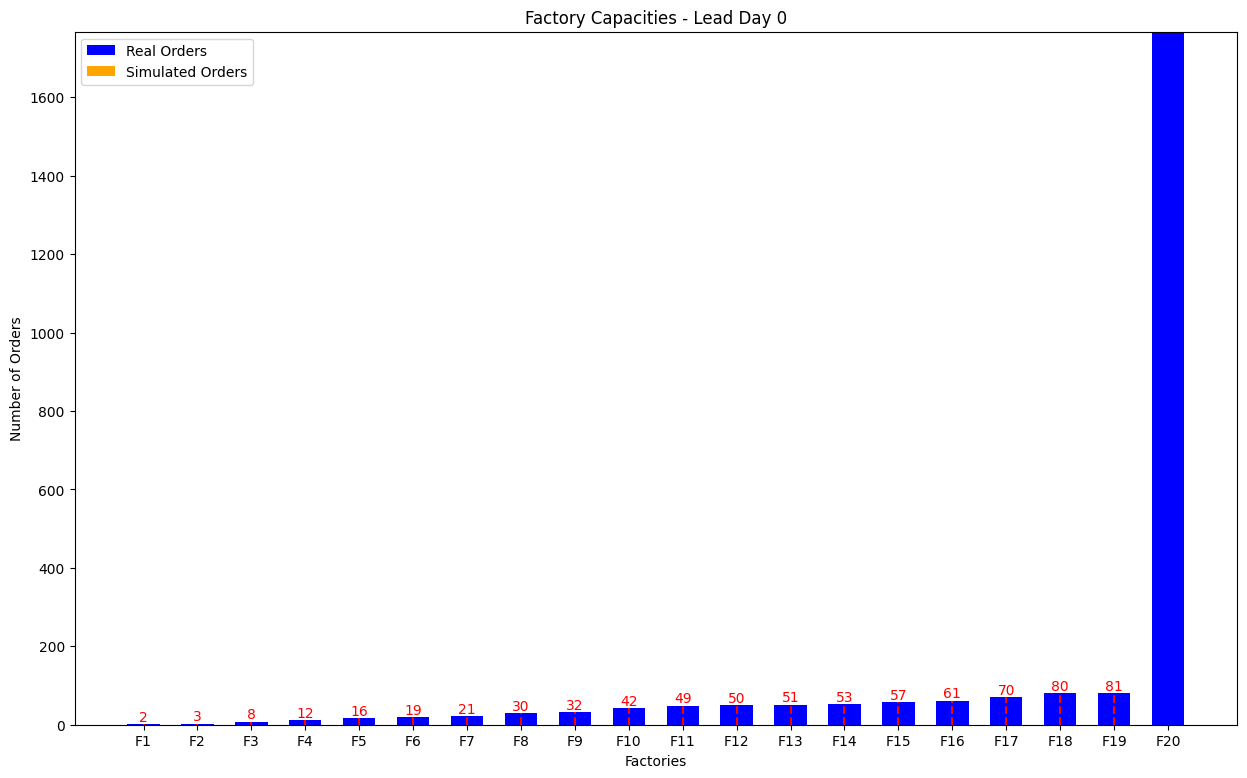

Plots have been generated.


In [28]:
# Plot for lead days 18, 12, 6, and 0
lead_days = [18, 12, 6, 0]

for lead_day in lead_days:
    # Load the allocated orders DataFrame
    allocated_orders_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_day}.csv')

    # Plot the factory capacities
    plot_factory_capacities(allocated_orders_df.copy(), factory_caps.copy(), lead_day)

print("Plots have been generated.")

# Temporal plot to show split of simulated orders vs real orders

In [29]:
def split_order_type(df):
    real_orders = df[df['order_type'] == 'real']['order_id'].nunique()
    simulated_orders = df[df['order_type'] == 'simulated']['order_id'].nunique()
    return real_orders, simulated_orders

In [30]:
# List of lead days
lead_days = list(range(18, -1, -1))

# Initialize lists to store aggregated data
real_orders = []
simulated_orders = []
lead_day_labels = []

# Loop through all lead days
for lead_day in lead_days:
    # Load the allocated orders DataFrame
    allocated_orders_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_day}.csv')
    
    # Aggregate data
    real_orders_count, simulated_orders_count = split_order_type(allocated_orders_df.copy())
    real_orders.append(real_orders_count)
    simulated_orders.append(simulated_orders_count)
    lead_day_labels.append(f'-{lead_day} days' if lead_day != 0 else 'Delivery date')

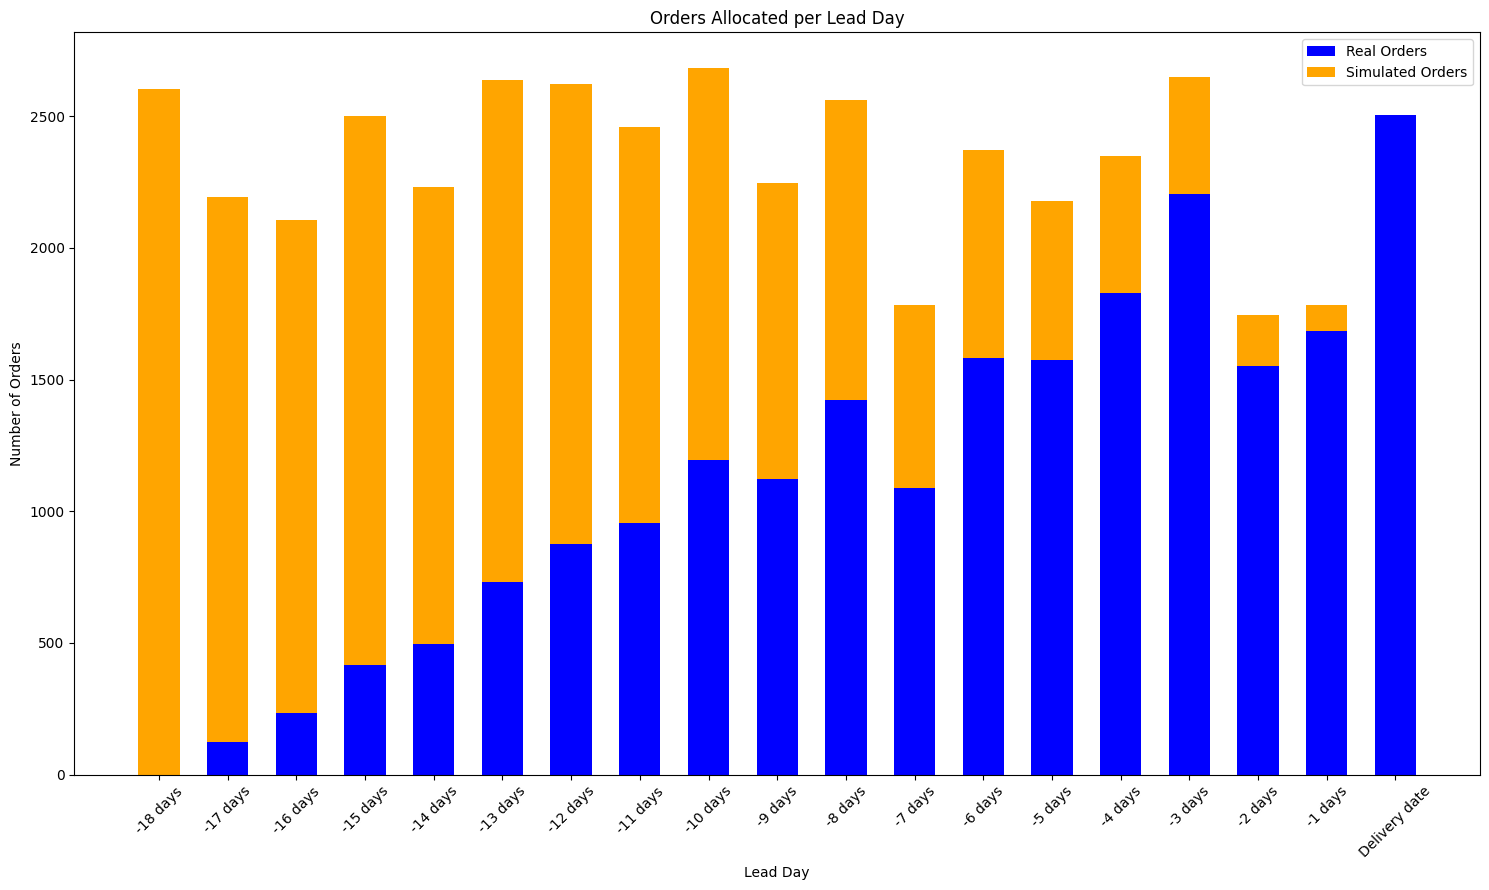

In [32]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 9))

bar_width = 0.6
bars_real = ax.bar(lead_day_labels, real_orders, bar_width, color='blue', label='Real Orders')
bars_simulated = ax.bar(lead_day_labels, simulated_orders, bar_width, bottom=real_orders, color='orange', label='Simulated Orders')

# Add labels and title
ax.set_xlabel('Lead Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Orders Allocated per Lead Day')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('allocated_orders_per_day.png')

# Aggregate items and Merge allocation dataframes
We aggregate the allocated orders dataframes in terms of item_id and we the merge the aggregated dataframes depending on which lead days we would like to compare.

In [33]:
def aggregate_items(allocated_orders_df, day):
    lead_day = 'lead_' + str(day)
    aggregated_df = allocated_orders_df.groupby(['item_id', 'site']).size().reset_index(name=lead_day)
    return aggregated_df

In [40]:
def merge_allocation(soft_df, hard_df, soft_num, hard_num):
    soft_day = 'lead_' + str(soft_num)
    hard_day = 'lead_' + str(hard_num)

    # Merge the two dataframes on 'item_id' and 'site'
    merged_df = pd.merge(soft_df, hard_df, on=['item_id', 'site'], how='outer')

    # Fill NaN values with zeros
    merged_df.fillna(0, inplace=True)

    # Ensure the integer type for lead_day columns
    if soft_day in merged_df.columns:
        merged_df[soft_day] = merged_df[soft_day].astype(int)
    else:
        merged_df[soft_day] = 0  # Add the column if it doesn't exist

    if hard_day in merged_df.columns:
        merged_df[hard_day] = merged_df[hard_day].astype(int)
    else:
        merged_df[hard_day] = 0  # Add the column if it doesn't exist

    return merged_df

In [41]:
merged_dir = 'merged'

# Create the merged directory if it doesn't exist
os.makedirs(merged_dir, exist_ok=True)

# List of lead days
lead_days = list(range(18, -1, -1))

# Load and aggregate the hard allocation for lead day 0
allocation_0 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_0.csv')
aggregated_0 = aggregate_items(allocation_0, 0)

# Loop through all lead days to aggregate and merge
for lead_day in lead_days:
    # Load the allocated orders DataFrame
    allocation_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_day}.csv')
    
    # Aggregate the items
    aggregated_df = aggregate_items(allocation_df, lead_day)
    
    # Merge with the hard allocation for lead day 0
    merged_df = merge_allocation(aggregated_df, aggregated_0, soft_num=lead_day, hard_num=0)
    
    # Save the merged DataFrame
    merged_df.to_csv(f'{merged_dir}/merged_lead_day_{lead_day}_0.csv', index=False)

print("Merged DataFrames have been saved.")

Merged DataFrames have been saved.


# Calculate wmape site and wmape global

In [42]:
def calculate_wmape_site(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    site_df = merged_df.copy()
    site_df['abs_error'] = (site_df[soft_col] - site_df[hard_col]).abs()

    # Calculate WMAPE_site
    wmape_site = site_df["abs_error"].sum() / total_forecast

    return site_df, wmape_site

In [43]:
def calculate_wmape_global(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    global_df = merged_df.copy()
    global_df = global_df.groupby('item_id').sum().reset_index()
    global_df['abs_error'] = (global_df[soft_col] - global_df[hard_col]).abs()
    global_df = global_df.drop(['site'], axis=1, errors='ignore')

    # Calculate WMAPE_global
    wmape_global = global_df["abs_error"].sum() / total_forecast

    return global_df, wmape_global

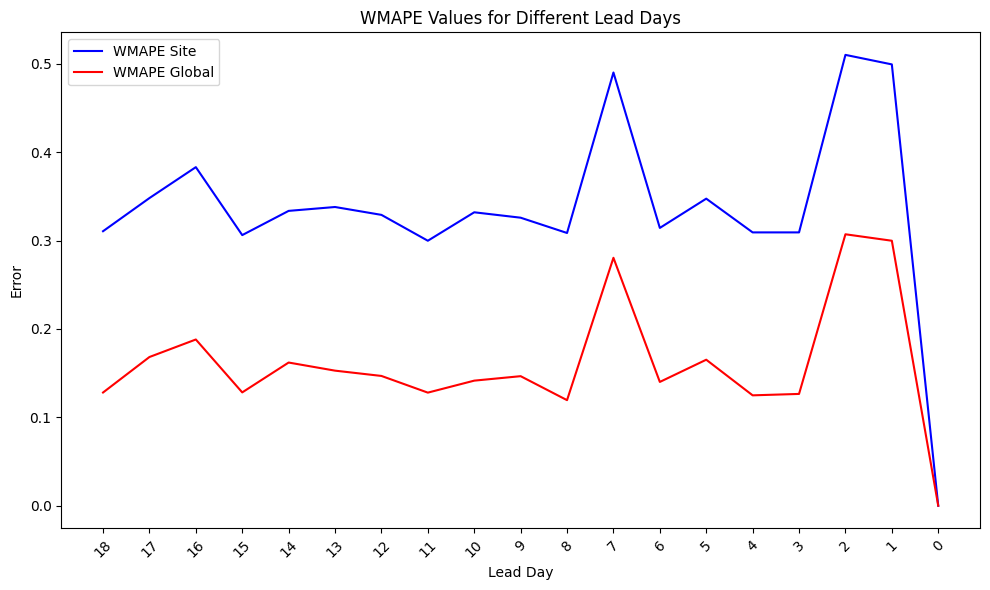

In [45]:
# List of lead days
lead_days = list(range(18, -1, -1))

# Initialize lists to store WMAPE values
wmape_site_values = []
wmape_global_values = []

# Loop through all lead days to calculate WMAPE
for lead_day in lead_days:
    # Load the merged DataFrame
    merged_df = pd.read_csv(f'{merged_dir}/merged_lead_day_{lead_day}_0.csv')
    
    # Calculate WMAPE for site and global
    soft_col = f'lead_{lead_day}'
    hard_col = 'lead_0'
    
    if lead_day == 0:
        wmape_site = 0
        wmape_global = 0
    else:
        _, wmape_site = calculate_wmape_site(merged_df, soft_col, hard_col)
        _, wmape_global = calculate_wmape_global(merged_df, soft_col, hard_col)
    
    # Append the WMAPE values to the lists
    wmape_site_values.append(wmape_site)
    wmape_global_values.append(wmape_global)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(lead_days, wmape_site_values, linestyle='-', color='b', label="WMAPE Site")
plt.plot(lead_days, wmape_global_values, linestyle='-', color='r', label="WMAPE Global")
plt.xlabel('Lead Day')
plt.ylabel('Error')
plt.title('WMAPE Values for Different Lead Days')
plt.xticks(lead_days, rotation=45)
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to have 0 at the end
plt.tight_layout()
plt.show()
plt.savefig('wmape.png')